In [1]:
!pip install matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import matplotlib.pyplot as plt

# Specify the folder path
folder_path = '/content/drive/MyDrive/cot+excel'

# Get a list of all Excel files in the folder
excel_files = [file for file in os.listdir(folder_path) if file.endswith(('.xls', '.xlsx'))]

# Create an empty list to store the DataFrames
dfs = []

# Loop through each Excel file and read it into a DataFrame
for file in excel_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_excel(file_path)
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Group data by 'Symbol' and sum 'Commercial Net Positions'
grouped_data = combined_df.groupby('Symbol')['Commercial Net Positions'].sum()

# # Create the bar chart
# plt.figure(figsize=(12, 6))  # Adjust figure size if needed
# plt.bar(grouped_data.index, grouped_data.values)
# plt.xlabel("Symbol")
# plt.ylabel("Commercial Net Positions")
# plt.title("Commercial Net Positions by Symbol")
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
# plt.tight_layout()
# plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyError: 'Group'

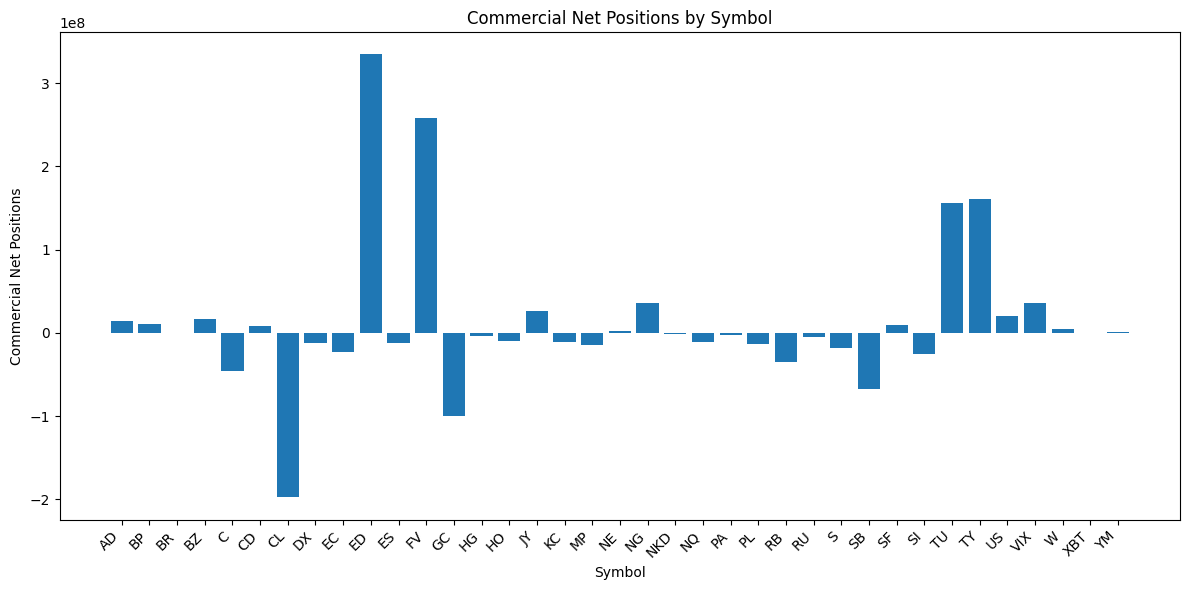

In [4]:
# Group data by 'Symbol' and sum 'Commercial Net Positions'
grouped_data = combined_df.groupby('Symbol')['Commercial Net Positions'].sum()

# Create the bar chart
plt.figure(figsize=(12, 6))  # Adjust figure size if needed
plt.bar(grouped_data.index, grouped_data.values)
plt.xlabel("Symbol")
plt.ylabel("Commercial Net Positions")
plt.title("Commercial Net Positions by Symbol")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [3]:
print(combined_df.columns)

Index(['Unnamed: 0', 'Date', 'Symbol', 'Open Interest', 'Open Interest Chg',
       'Open Interest Pct Chg', 'OpenI Strength Index', 'Comms Net PCT OI',
       'Comm Long Pct OI', 'Comm Short Pct OI', 'Commercial Net Positions',
       'Commercial Net Chg', 'Commercial Gross Longs',
       'Commercial Gross Shorts', 'Comm Long-Short Ratio',
       'Comm Strength Index', 'Comm Move Index', 'Specs Net Pct OI',
       'Specs Long Pct OI', 'Specs Short Pct OI', 'Speculators Net Positions',
       'Speculators Net Chg', 'Speculators Gross Longs',
       'Speculators Gross Shorts', 'Specs Long-Short Ratio',
       'Specs Strength Index', 'Specs Move Index', 'Smalls Net Pct OI',
       'Smalls Long Pct OI', 'Smalls Short Pct OI',
       'Small Traders Net Positions', 'Small Traders Net Chg',
       'Smalls Gross Longs', 'Smalls Gross Shorts', 'Smalls Long-Short Ratio',
       'Smalls Strength Index', 'Smalls Move Index'],
      dtype='object')


In [5]:
import os
import pandas as pd
import numpy as np
from typing import List, Dict, Union, Optional, Tuple
from datetime import datetime
from dataclasses import dataclass
from functools import lru_cache

@dataclass
class COTAnalysisResult:
    """Data class to store analysis results"""
    analysis_type: str
    symbol: str
    data: Union[pd.DataFrame, Dict, str]
    timestamp: datetime = datetime.now()

class COTAnalyzer:
    """Enhanced Commitments of Traders (COT) data analyzer"""

    # Column groups for different trader categories
    TRADER_COLUMNS = {
        'commercial': {
            'net_pct': 'Comms Net PCT OI',
            'long_pct': 'Comm Long Pct OI',
            'short_pct': 'Comm Short Pct OI',
            'net_positions': 'Commercial Net Positions',
            'net_change': 'Commercial Net Chg',
            'gross_longs': 'Commercial Gross Longs',
            'gross_shorts': 'Commercial Gross Shorts',
            'ls_ratio': 'Comm Long-Short Ratio',
            'strength_index': 'Comm Strength Index',
            'move_index': 'Comm Move Index'
        },
        'speculator': {
            'net_pct': 'Specs Net Pct OI',
            'long_pct': 'Specs Long Pct OI',
            'short_pct': 'Specs Short Pct OI',
            'net_positions': 'Speculators Net Positions',
            'net_change': 'Speculators Net Chg',
            'gross_longs': 'Speculators Gross Longs',
            'gross_shorts': 'Speculators Gross Shorts',
            'ls_ratio': 'Specs Long-Short Ratio',
            'strength_index': 'Specs Strength Index',
            'move_index': 'Specs Move Index'
        },
        'small': {
            'net_pct': 'Smalls Net Pct OI',
            'long_pct': 'Smalls Long Pct OI',
            'short_pct': 'Smalls Short Pct OI',
            'net_positions': 'Small Traders Net Positions',
            'net_change': 'Small Traders Net Chg',
            'gross_longs': 'Smalls Gross Longs',
            'gross_shorts': 'Smalls Gross Shorts',
            'ls_ratio': 'Smalls Long-Short Ratio',
            'strength_index': 'Smalls Strength Index',
            'move_index': 'Smalls Move Index'
        }
    }

    def __init__(self, folder_path: str):
        """Initialize COT Analyzer with data folder path."""
        self.folder_path = folder_path
        self.data: Optional[pd.DataFrame] = None
        self.symbols: List[str] = []
        self._load_data()

    def _load_data(self) -> None:
        """Load and process all Excel files from the specified folder."""
        try:
            # Get all Excel files in the folder
            excel_files = [
                file for file in os.listdir(self.folder_path)
                if file.endswith(('.xls', '.xlsx'))
            ]

            if not excel_files:
                raise FileNotFoundError(f"No Excel files found in {self.folder_path}")

            # Load and combine all Excel files
            dfs = []
            for file in excel_files:
                file_path = os.path.join(self.folder_path, file)
                try:
                    df = pd.read_excel(file_path)
                    dfs.append(df)
                except Exception as e:
                    print(f"Error loading {file}: {str(e)}")

            if not dfs:
                raise ValueError("No valid data loaded from Excel files")

            # Combine all dataframes
            self.data = pd.concat(dfs, ignore_index=True)

            # Clean and process the data
            self._process_data()

        except Exception as e:
            raise RuntimeError(f"Error loading data: {str(e)}")

    def _process_data(self) -> None:
        """Process and clean the loaded data."""
        if self.data is None:
            return

        # Convert date column to datetime
        self.data['Date'] = pd.to_datetime(self.data['Date'])

        # Sort by date and symbol
        self.data.sort_values(['Symbol', 'Date'], inplace=True)

        # Get unique symbols
        self.symbols = sorted(self.data['Symbol'].unique())

        # Calculate additional metrics
        self._calculate_momentum_indicators()

    def _calculate_momentum_indicators(self) -> None:
        """Calculate additional momentum and trend indicators."""
        if self.data is None:
            return

        # Group by symbol for calculations
        for symbol in self.symbols:
            mask = self.data['Symbol'] == symbol

            # Calculate rolling averages and momentum
            for trader_type in self.TRADER_COLUMNS:
                cols = self.TRADER_COLUMNS[trader_type]

                # 4-week momentum
                self.data.loc[mask, f'{trader_type}_momentum_4w'] = (
                    self.data.loc[mask, cols['net_positions']]
                    .diff(4)
                    .rolling(window=4)
                    .mean()
                )

                # 12-week trend
                self.data.loc[mask, f'{trader_type}_trend_12w'] = (
                    self.data.loc[mask, cols['net_positions']]
                    .rolling(window=12)
                    .mean()
                )

    @lru_cache(maxsize=100)
    def get_symbol_data(self, symbol: str, lookback_periods: int = 52) -> Optional[pd.DataFrame]:
        """Get processed data for a specific symbol with caching."""
        if self.data is None or symbol not in self.symbols:
            return None

        symbol_data = self.data[self.data['Symbol'] == symbol].copy()
        return symbol_data.tail(lookback_periods)

    def analyze_sentiment(self, symbol: str, lookback_periods: int = 52) -> Dict:
        """
        Analyze market sentiment for a symbol with enhanced metrics.
        """
        try:
            symbol_data = self.get_symbol_data(symbol, lookback_periods)
            if symbol_data is None:
                return {"error": f"Symbol {symbol} not found"}

            # Calculate weighted sentiment score
            sentiment_score = (
                0.5 * np.sign(symbol_data[self.TRADER_COLUMNS['speculator']['net_pct']].mean()) +
                0.3 * np.sign(symbol_data[self.TRADER_COLUMNS['commercial']['net_pct']].mean()) +
                0.2 * np.sign(symbol_data[self.TRADER_COLUMNS['small']['net_pct']].mean())
            )

            # Calculate positioning scores for each trader type
            positioning_scores = {}
            for trader_type, cols in self.TRADER_COLUMNS.items():
                positioning_scores[f"{trader_type}_positioning"] = {
                    'net_pct': float(symbol_data[cols['net_pct']].mean()),
                    'ls_ratio': float(symbol_data[cols['ls_ratio']].mean()),
                    'strength_index': float(symbol_data[cols['strength_index']].mean()),
                    'momentum': float(symbol_data[f'{trader_type}_momentum_4w'].iloc[-1])
                }

            return {
                'symbol': symbol,
                'analysis_date': symbol_data['Date'].max().strftime('%Y-%m-%d'),
                'overall_sentiment': 'Bullish' if sentiment_score > 0 else 'Bearish',
                'sentiment_score': float(sentiment_score),
                'positioning_analysis': positioning_scores,
                'open_interest': {
                    'current': float(symbol_data['Open Interest'].iloc[-1]),
                    'change_pct': float(symbol_data['Open Interest Pct Chg'].mean()),
                    'strength_index': float(symbol_data['OpenI Strength Index'].mean())
                }
            }
        except Exception as e:
            return {"error": f"Error analyzing sentiment: {str(e)}"}

    def analyze_trends(self, symbol: str, window: int = 20) -> Dict:
        """
        Analyze trends for a symbol with enhanced metrics.
        """
        try:
            symbol_data = self.get_symbol_data(symbol, window)
            if symbol_data is None:
                return {"error": f"Symbol {symbol} not found"}

            trend_analysis = {}

            # Analyze trends for each trader type
            for trader_type, cols in self.TRADER_COLUMNS.items():
                trend_analysis[f"{trader_type}_trends"] = {
                    'net_position_trend': float(symbol_data[cols['net_positions']].diff().mean()),
                    'net_position_momentum': float(symbol_data[f'{trader_type}_momentum_4w'].iloc[-1]),
                    'long_short_trend': float(symbol_data[cols['ls_ratio']].diff().mean()),
                    'strength_trend': float(symbol_data[cols['strength_index']].diff().mean())
                }

            # Add overall market trends
            trend_analysis['market_trends'] = {
                'open_interest_trend': float(symbol_data['Open Interest'].diff().mean()),
                'open_interest_strength': float(symbol_data['OpenI Strength Index'].mean()),
                'dominant_trader': self._identify_dominant_trader(symbol_data)
            }

            return trend_analysis
        except Exception as e:
            return {"error": f"Error analyzing trends: {str(e)}"}

    def _identify_dominant_trader(self, data: pd.DataFrame) -> str:
        """Identify the dominant trader type based on net position impact."""
        latest_data = data.iloc[-1]

        positions = {
            'Commercial': abs(latest_data['Commercial Net Positions']),
            'Speculator': abs(latest_data['Speculators Net Positions']),
            'Small': abs(latest_data['Small Traders Net Positions'])
        }

        return max(positions.items(), key=lambda x: x[1])[0]

    def get_available_symbols(self) -> List[str]:
        """Get list of available symbols."""
        return self.symbols.copy()

In [7]:
folder_path = '/content/drive/MyDrive/cot+excel'
# Initialize the analyzer
analyzer = COTAnalyzer(folder_path)

# Get sentiment analysis for a symbol
sentiment = analyzer.analyze_sentiment("YM")
print(sentiment)

# Get trend analysis
trends = analyzer.analyze_trends("AD")
print(trends)

# Get available symbols
symbols = analyzer.get_available_symbols()
print(symbols)

{'symbol': 'AD', 'analysis_date': '1970-01-01', 'overall_sentiment': 'Bearish', 'sentiment_score': 0.0, 'positioning_analysis': {'commercial_positioning': {'net_pct': 18.377618463953404, 'ls_ratio': 1.8629138816131723, 'strength_index': 52.33192546310495, 'momentum': 84136.75}, 'speculator_positioning': {'net_pct': -18.765470294880938, 'ls_ratio': 0.7075199982355648, 'strength_index': 49.28951475595915, 'momentum': -76799.25}, 'small_positioning': {'net_pct': 0.38785183092753744, 'ls_ratio': 1.113137594223915, 'strength_index': 50.4220029180514, 'momentum': -7337.5}}, 'open_interest': {'current': 182872.0, 'change_pct': 0.7164085382924081, 'strength_index': 56.817585298035425}}
{'commercial_trends': {'net_position_trend': 2112.2631578947367, 'net_position_momentum': 84136.75, 'long_short_trend': 0.06878925874825426, 'strength_trend': 1.258850582500305}, 'speculator_trends': {'net_position_trend': -1711.8947368421052, 'net_position_momentum': -76799.25, 'long_short_trend': -0.0165375871

{'symbol': 'YM', 'analysis_date': '1970-01-01', 'overall_sentiment': 'Bullish', 'sentiment_score': 0.4, 'positioning_analysis': {'commercial_positioning': {'net_pct': -15.835081060618572, 'ls_ratio': 0.777298272467418, 'strength_index': 16.534191755132117, 'momentum': 2120.5}, 'speculator_positioning': {'net_pct': 12.951299692669544, 'ls_ratio': 2.023421586233351, 'strength_index': 80.27950077441018, 'momentum': -3819.0}, 'small_positioning': {'net_pct': 2.8837813679490294, 'ls_ratio': 1.2309506750586436, 'strength_index': 74.45394869178273, 'momentum': 1698.5}}, 'open_interest': {'current': 83957.0, 'change_pct': -0.07555426440753456, 'strength_index': 60.01022206132636}}


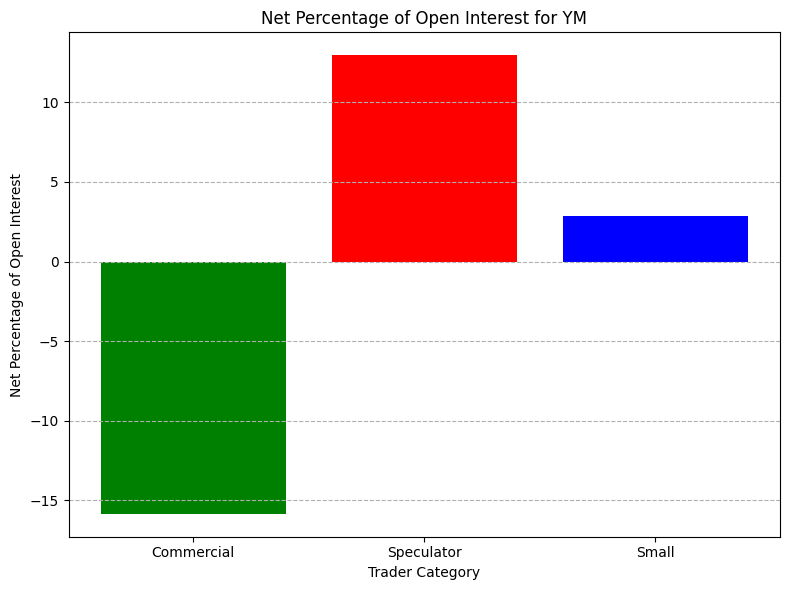

In [9]:
import matplotlib.pyplot as plt


sentiment = analyzer.analyze_sentiment("YM")
print(sentiment)
# data = {'symbol': 'AD', 'analysis_date': '1970-01-01', 'overall_sentiment': 'Bearish', 'sentiment_score': 0.0, 'positioning_analysis': {'commercial_positioning': {'net_pct': 18.377618463953404, 'ls_ratio': 1.8629138816131723, 'strength_index': 52.33192546310495, 'momentum': 84136.75}, 'speculator_positioning': {'net_pct': -18.765470294880938, 'ls_ratio': 0.7075199982355648, 'strength_index': 49.28951475595915, 'momentum': -76799.25}, 'small_positioning': {'net_pct': 0.38785183092753744, 'ls_ratio': 1.113137594223915, 'strength_index': 50.4220029180514, 'momentum': -7337.5}}, 'open_interest': {'current': 182872.0, 'change_pct': 0.7164085382924081, 'strength_index': 56.817585298035425}}
data=sentiment

categories = ['Commercial', 'Speculator', 'Small']
net_pcts = [data['positioning_analysis']['commercial_positioning']['net_pct'],
            data['positioning_analysis']['speculator_positioning']['net_pct'],
            data['positioning_analysis']['small_positioning']['net_pct']]

plt.figure(figsize=(8, 6))
plt.bar(categories, net_pcts, color=['green', 'red', 'blue'])
plt.title(f"Net Percentage of Open Interest for {data['symbol']}")
plt.xlabel("Trader Category")
plt.ylabel("Net Percentage of Open Interest")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()